In [20]:
%load_ext autoreload
%autoreload 2

import os
os.environ['PATH'] = './ffmpeg-7.0.2-amd64-static:' + os.environ['PATH']

from time import time
from datetime import datetime
import random
import torch
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 500)


import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import HTML
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from arguments import prepare_finetuning_args, Args
from dataset import build_dataset
from torch.utils.data import DataLoader
from engine_for_finetuning import validation_one_epoch
import models
from timm.models import create_model

from dataset.build_dataset import calc_tile_offsets
from view_test_tiles import plot_image, draw_tiles_and_center, create_gif_pil, draw_timestamp_in_bottom_right, display_video_clip
from medicane_utils.geo_const import latcorners, loncorners, x_center, y_center, create_basemap_obj

from model_analysis import predict_label, get_path_pred_label, create_df_predictions



Impossibile caricare la libreria torch dynamo


### Carico il dataset

In [3]:
args = prepare_finetuning_args()
##### prende da val_supervised.csv
dataset_val, _ = build_dataset(is_train=False, test_mode=False, args=args)  

data_loader_val = DataLoader(
    dataset_val,
    batch_size=args.batch_size,
    shuffle=True,         # Per estrarre sample casuali
    num_workers=args.num_workers,
    pin_memory=args.pin_mem,
    drop_last=False
)

get_prediction = False

Number of the class = 2


In [4]:
df_validation = pd.read_csv('val_supervised.csv')

In [ ]:
from medicane_utils.load_files import extract_dates_pattern_airmass_rgb_20200101_0000
time_col_splitted = df_validation.path.str.split('_').str[0].str.split('/').str[-1]  #.apply(lambda x: datetime(x) > datetime(2020, 1, 1))

In [30]:
df_validation["datetime_col"] = time_col_splitted.apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))

In [35]:
df_validation#[df_validation["datetime_col"] < datetime(2020, 1, 2)]

path  start  end  label  \
0        ../airmassRGB/supervised/17-09-2020_1830_0_0      1   16      1   
1        ../airmassRGB/supervised/17-09-2020_1950_0_0      1   16      1   
2        ../airmassRGB/supervised/17-09-2020_2110_0_0      1   16      1   
3        ../airmassRGB/supervised/17-09-2020_2230_0_0      1   16      1   
4        ../airmassRGB/supervised/17-09-2020_2350_0_0      1   16      1   
..                                                ...    ...  ...    ...   
995  ../airmassRGB/supervised/06-11-2020_0405_448_196      1   16      0   
996    ../airmassRGB/supervised/01-12-2020_1725_896_0      1   16      0   
997    ../airmassRGB/supervised/30-12-2020_0340_672_0      1   16      0   
998  ../airmassRGB/supervised/23-09-2020_2350_896_196      1   16      0   
999    ../airmassRGB/supervised/12-04-2020_1520_448_0      1   16      0   

    datetime_col  
0     2020-09-17  
1     2020-09-17  
2     2020-09-17  
3     2020-09-17  
4     2020-09-17  
..           ...  
995   2020-11-06  
996   2020-12-01  
997   2020-12-30  
998   2020-09-23  
999   2020-04-12  

[1000 rows x 5 columns]

In [5]:
df_data = pd.read_csv("all_data_wo_overlap_tiles.csv", dtype={
    "path": 'string',
    "tile_offset_x": 'int16',
    "tile_offset_y": 'int16',
    "label": 'int16',
    "lat": 'float32',
    "lon": 'float32',
    "x_pix": 'Int16',
    "y_pix": 'Int16',
    "name": 'string'
}, parse_dates=['datetime'])
df_data.drop(columns='Unnamed: 0', inplace=True)


In [134]:
#df_data[df_data.lat.apply(lambda x: len(x)>0)]
mask = df_data.lat.notna()
df_data['source'] = np.nan
df_data.loc[mask, 'source'] = 'CL7'

In [136]:
df_data[mask]#[df_data.label == 1].iloc[:200]#.shape[0]

path            datetime  \
12121    ../fromgcloud/airmass_rgb_20111105_0500.png 2011-11-05 05:00:00   
12131    ../fromgcloud/airmass_rgb_20111105_0505.png 2011-11-05 05:05:00   
12141    ../fromgcloud/airmass_rgb_20111105_0510.png 2011-11-05 05:10:00   
12151    ../fromgcloud/airmass_rgb_20111105_0515.png 2011-11-05 05:15:00   
12161    ../fromgcloud/airmass_rgb_20111105_0520.png 2011-11-05 05:20:00   
...                                              ...                 ...   
1087983  ../fromgcloud/airmass_rgb_20201228_0135.png 2020-12-28 01:35:00   
1087993  ../fromgcloud/airmass_rgb_20201228_0140.png 2020-12-28 01:40:00   
1088003  ../fromgcloud/airmass_rgb_20201228_0145.png 2020-12-28 01:45:00   
1088013  ../fromgcloud/airmass_rgb_20201228_0150.png 2020-12-28 01:50:00   
1088023  ../fromgcloud/airmass_rgb_20201228_0155.png 2020-12-28 01:55:00   

         tile_offset_x  tile_offset_y  label    lat    lon  x_pix  y_pix  \
12121              224              0      1  42.34   1.05    287     89   
12131              224              0      1  42.34   1.05    287     89   
12141              224              0      1  42.34   1.05    287     89   
12151              224              0      1  42.34   1.05    287     89   
12161              224              0      1  42.34   1.05    287     89   
...                ...            ...    ...    ...    ...    ...    ...   
1087983            672              0      1  44.50  17.00    696     39   
1087993            672              0      1  44.50  17.00    696     39   
1088003            672              0      1  44.50  17.00    696     39   
1088013            672              0      1  44.50  17.00    696     39   
1088023            672              0      1  44.50  17.00    696     39   

         name source  
12121    Rolf    CL7  
12131    Rolf    CL7  
12141    Rolf    CL7  
12151    Rolf    CL7  
12161    Rolf    CL7  
...       ...    ...  
1087983  <NA>    CL7  
1087993  <NA>    CL7  
1088003  <NA>    CL7  
1088013  <NA>    CL7  
1088023  <NA>    CL7  

[33421 rows x 11 columns]

df_data = pd.read_csv("all_data_all_methods_tracks_complete.csv", dtype={
        "path": 'string',
        "tile_offset_x": 'int16',
        "tile_offset_y": 'int16',
        "label": 'category',
        "lat": 'object',  # non più float16
        "lon": 'object',  # non più float16
        "x_pix": 'object', # non più Int16
        "y_pix": 'object', # non più Int16
        "name": 'string',
        "source": 'string'
    }, parse_dates=['datetime'])

In [ ]:
#df_data.path = df_data.path.str.replace("../fromgcloud/", "E:\\Medicanes_Data\\from_gcloud\\")

In [6]:
df_data.tile_offset_x.unique()

array([  0, 224, 448, 672, 896], dtype=int16)

### carica modello

In [ ]:
# voglio prendere le predizioni
get_prediction = True
args.test_mode = True

# istanzia l'oggetto del modello 
print(f"Creating model: {args.model} (nb_classes={args.nb_classes})")
model = create_model(
    args.model,
    num_classes=args.nb_classes,
    drop_rate=0.0,
    drop_path_rate=args.drop_path,
    #attn_drop_rate=0.0,
    drop_block_rate=None,
    **args.__dict__
)
model.to(args.device)
model.eval()  

Creating model: vit_giant_patch14_224 (nb_classes=2)


### vedi singola tile

In [11]:
def get_time_from_row(folder_path):
    stringa = folder_path[0].split('/')[-1]
    data = stringa.split('_')[0]
    ora = stringa.split('_')[1]
    ora = ora[:2] + ':' + ora[2:]
    #data = pd.to_datetime(data)
    time = pd.to_datetime(data + " " + ora, format="%d-%m-%Y %H:%M")
    return time

In [ ]:
basemap = create_basemap_obj()
# DA CANCELLARE: USARE create_med_video
def create_labeled_images_with_tiles(df_grouped, nome_gif):
# in ogni group abbiamo una sola immagine (un istante temporale)
# e tutte le tiles con le rispettive label. 
# possiamo avere più cicloni con le rispettive coordinate, da trovare uniche, perché si ripetono in tutte le tiles vicine
    lista_immagini = []
    for path_img, group_df in df_grouped:
        # Apriamo l'immagine
        img = Image.open(path_img)#.convert("RGB")
        #center_px_list = (x_pix, y_pix)
        center_px_list = group_df[['x_pix','y_pix']].value_counts().index.values
        #labeled_tiles_offsets = get_tile_labels(lat, lon)
        labeled_tiles_offsets = group_df['label'].values

        date_str = group_df['datetime'].unique()[0].strftime(" %H:%M %d-%m-%Y")
        
        # Disegniamo
        default_offsets = calc_tile_offsets()
        out_img = draw_tiles_and_center(img, default_offsets,
            cyclone_centers=center_px_list,
            labeled_tiles_offsets=labeled_tiles_offsets
            )
        stamped_img = draw_timestamp_in_bottom_right(out_img, date_str, margin=15)
        pi_img = plot_image(stamped_img, basemap, draw_parallels_meridians=True)
        lista_immagini.append(pi_img)
        #display(out_img)
    
    lista_immagini[0].save(nome_gif, save_all=True, append_images=lista_immagini[1:], duration=200, loop=0)

In [14]:
samples = next(iter(data_loader_val))  # samples è una tupla tipicamente (video, label, index, ...)
videos = samples[0]  # tensore di shape [B, C, T, H, W] 
labels = samples[1]  # shape [B]
folder_path = samples[2]

time = get_time_from_row(folder_path)

if get_prediction:
    pred_classes = predict_label(model, videos)
else:
    pred_classes = -1
    
label = labels.detach().cpu().numpy()
print(f"Label reale: {label}, predetta: {pred_classes}")


v0 = videos[0]  # shape [C, T, H, W]
v0 = v0.permute(1, 2, 3, 0).cpu()  # [T, H, W, C]

v0_min = v0.min()
v0_max = v0.max()
v0_vis = (v0 - v0_min) / (v0_max - v0_min + 1e-5)  # normalizzato [0,1]

video_display = display_video_clip(v0_vis)
display(video_display)


Label reale: [1], predetta: [0]


In [ ]:
m_sup = df_data.datetime <= time 
m_inf = df_data.datetime >= (time - pd.Timedelta(minutes=80))
df_res = df_data[m_sup & m_inf]

grouped = df_res.groupby("path", dropna=False)
# USARE create_med_video - anzi meglio make_animation
create_labeled_images_with_tiles(grouped, 'test_from_tile4.gif')

# verifica le predizioni su tutto il dataset di validazione

In [11]:
all_paths, all_preds, all_labels = get_path_pred_label(model, data_loader_val)

##### verifica accuratezza

In [12]:
all_labels_array = np.array(all_labels)
all_preds_array = np.array(all_preds)
all_labels_array.sum(), all_preds_array.sum(), len(all_labels_array), len(all_preds_array)

(500, 400, 1000, 1000)

In [13]:
corretti = all_labels_array == all_preds_array
corretti.sum() / len(corretti)

0.738

##### crea e riempi il dataframe con le predizioni

In [15]:
df_predictions = create_df_predictions(all_paths, all_preds, all_labels)

In [42]:
df_data[df_data.path.str.contains('20200917_1730')]

path            datetime  \
796270  ../fromgcloud/airmass_rgb_20200917_1730.png 2020-09-17 17:30:00   
796271  ../fromgcloud/airmass_rgb_20200917_1730.png 2020-09-17 17:30:00   
796272  ../fromgcloud/airmass_rgb_20200917_1730.png 2020-09-17 17:30:00   
796273  ../fromgcloud/airmass_rgb_20200917_1730.png 2020-09-17 17:30:00   
796274  ../fromgcloud/airmass_rgb_20200917_1730.png 2020-09-17 17:30:00   
796275  ../fromgcloud/airmass_rgb_20200917_1730.png 2020-09-17 17:30:00   
796276  ../fromgcloud/airmass_rgb_20200917_1730.png 2020-09-17 17:30:00   
796277  ../fromgcloud/airmass_rgb_20200917_1730.png 2020-09-17 17:30:00   
796278  ../fromgcloud/airmass_rgb_20200917_1730.png 2020-09-17 17:30:00   
796279  ../fromgcloud/airmass_rgb_20200917_1730.png 2020-09-17 17:30:00   

        tile_offset_x  tile_offset_y  label        lat        lon  x_pix  \
796270              0              0      0        NaN        NaN   <NA>   
796271            224              0      0        NaN        NaN   <NA>   
796272            448              0      0        NaN        NaN   <NA>   
796273            672              0      1  37.529999  19.469999    788   
796274            896              0      0        NaN        NaN   <NA>   
796275              0            196      0        NaN        NaN   <NA>   
796276            224            196      0        NaN        NaN   <NA>   
796277            448            196      0        NaN        NaN   <NA>   
796278            672            196      1  37.529999  19.469999    788   
796279            896            196      0        NaN        NaN   <NA>   

        y_pix   name  
796270   <NA>  Ianos  
796271   <NA>  Ianos  
796272   <NA>  Ianos  
796273    207  Ianos  
796274   <NA>  Ianos  
796275   <NA>  Ianos  
796276   <NA>  Ianos  
796277   <NA>  Ianos  
796278    207  Ianos  
796279   <NA>  Ianos

##### -> sostituire con create_df_video_from_master_df  from build_dataset

In [ ]:
from build_dataset import get_gruppi_date, create_tile_videos, group_df_by_offsets

def get_df_videos(df_data):
    gruppi_date = get_gruppi_date(df_data)
    len(df_data), len(gruppi_date)
    all_videos = []
    for df in gruppi_date:
        df_offsets_groups = group_df_by_offsets(df)
        df_videos = create_tile_videos(df_offsets_groups, supervised=True)
        all_videos.append(df_videos)
    all_df_videos = pd.concat(all_videos)
    all_df_videos.shape[0]

    return all_df_videos

In [ ]:
all_df_videos = get_df_videos(df_data)

In [37]:
all_df_videos[all_df_videos.path.str.contains('17-09-2020_1830_0_0')]

video_id  tile_offset_x  tile_offset_y                 path  label  \
3105      3105              0              0  17-09-2020_1830_0_0      0   

              start_time            end_time  \
3105 2020-09-17 17:10:00 2020-09-17 18:30:00   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               orig_paths  
3105  [../fromgcloud/airmass_rgb_20200917_1710.png, ../fromgcloud/airmass_rgb_20200917_1715.png, ../fromgcloud/airmass_rgb_20200917_1720.png, ../fromgcloud/airmass_rgb_20200917_1725.png, ../fromgcloud/airmass_rgb_20200917_1730.png, ../fromgcloud/airmass_rgb_20200917_1735.png, ../fromgcloud/airmass_rgb_20200917_1740.png, ../fromgcloud/airmass_rgb_20200917_1745.png, ../fromgcloud/airmass_rgb_20200917_1750.png, ../fromgcloud/airmass_rgb_20200917_1755.png, ../fromgcloud/airmass_rgb_20200917_1800.png, ...

In [35]:
all_df_videos.shape[0]

73540

In [10]:
len(df_data) / len(all_df_videos)  # ?circa? = num frames che compongono un video

16.01359804188197

##### fin quì.  da quì in poi ...

In [16]:
df_filtrato_on_video_path = all_df_videos.merge(df_predictions, on='path')
df_filtrato_on_video_path.shape[0]

1000

In [17]:
m = df_filtrato_on_video_path.label == df_filtrato_on_video_path.labels

In [110]:
df_validation[df_validation.path.str.contains('17-09-2020_1830_0_0')]

path  start  end  label
0  ../airmassRGB/supervised/17-09-2020_1830_0_0      1   16      1

In [ ]:
df_filtrato_on_video_path[~m].head(10)

In [ ]:
df_filtrato_on_video_path.head(2)

In [91]:
all(df_filtrato_on_video_path.label == df_filtrato_on_video_path.labels)

False

In [ ]:
# video_pred_2_img_pred from model_analysis

# Espando dataframe con le associazioni path_offsets -> predictions
records = []
for _, row in df_filtrato_on_video_path.iterrows():
    for orig_path in row['orig_paths']:
        records.append({
            'path': orig_path,
            'predictions': row['predictions'],
            'tmp_label': row['labels'],
            'tile_offset_x': row['tile_offset_x'],
            'tile_offset_y': row['tile_offset_y']
        })

# Li trasformiamo in un nuovo DataFrame
df_mapping = pd.DataFrame(records)
df_mapping[['path', 'tile_offset_x', 'tile_offset_y']].duplicated().sum()
#Non ci sono path duplicati se in combinazione con gli offsets


0

In [140]:
df_mapping

path  predictions  tmp_label  \
0      ../fromgcloud/airmass_rgb_20200412_1400.png            1          0   
1      ../fromgcloud/airmass_rgb_20200412_1405.png            1          0   
2      ../fromgcloud/airmass_rgb_20200412_1410.png            1          0   
3      ../fromgcloud/airmass_rgb_20200412_1415.png            1          0   
4      ../fromgcloud/airmass_rgb_20200412_1420.png            1          0   
...                                            ...          ...        ...   
15995  ../fromgcloud/airmass_rgb_20201225_1635.png            0          0   
15996  ../fromgcloud/airmass_rgb_20201225_1640.png            0          0   
15997  ../fromgcloud/airmass_rgb_20201225_1645.png            0          0   
15998  ../fromgcloud/airmass_rgb_20201225_1650.png            0          0   
15999  ../fromgcloud/airmass_rgb_20201225_1655.png            0          0   

       tile_offset_x  tile_offset_y  
0                  0              0  
1                  0              0  
2                  0              0  
3                  0              0  
4                  0              0  
...              ...            ...  
15995            896            196  
15996            896            196  
15997            896            196  
15998            896            196  
15999            896            196  

[16000 rows x 5 columns]

In [141]:
# ottengo il dataframe per creare i video
df_data_merg = df_mapping.merge(df_data, on=['path', 'tile_offset_x', 'tile_offset_y'], how='left').drop(columns='label').rename(columns={'tmp_label':'label'})

In [142]:
df_data_merg

path  predictions  label  \
0      ../fromgcloud/airmass_rgb_20200412_1400.png            1      0   
1      ../fromgcloud/airmass_rgb_20200412_1405.png            1      0   
2      ../fromgcloud/airmass_rgb_20200412_1410.png            1      0   
3      ../fromgcloud/airmass_rgb_20200412_1415.png            1      0   
4      ../fromgcloud/airmass_rgb_20200412_1420.png            1      0   
...                                            ...          ...    ...   
15995  ../fromgcloud/airmass_rgb_20201225_1635.png            0      0   
15996  ../fromgcloud/airmass_rgb_20201225_1640.png            0      0   
15997  ../fromgcloud/airmass_rgb_20201225_1645.png            0      0   
15998  ../fromgcloud/airmass_rgb_20201225_1650.png            0      0   
15999  ../fromgcloud/airmass_rgb_20201225_1655.png            0      0   

       tile_offset_x  tile_offset_y            datetime  lat  lon  x_pix  \
0                  0              0 2020-04-12 14:00:00  NaN  NaN   <NA>   
1                  0              0 2020-04-12 14:05:00  NaN  NaN   <NA>   
2                  0              0 2020-04-12 14:10:00  NaN  NaN   <NA>   
3                  0              0 2020-04-12 14:15:00  NaN  NaN   <NA>   
4                  0              0 2020-04-12 14:20:00  NaN  NaN   <NA>   
...              ...            ...                 ...  ...  ...    ...   
15995            896            196 2020-12-25 16:35:00  NaN  NaN   <NA>   
15996            896            196 2020-12-25 16:40:00  NaN  NaN   <NA>   
15997            896            196 2020-12-25 16:45:00  NaN  NaN   <NA>   
15998            896            196 2020-12-25 16:50:00  NaN  NaN   <NA>   
15999            896            196 2020-12-25 16:55:00  NaN  NaN   <NA>   

       y_pix  name source  
0       <NA>    []    NaN  
1       <NA>    []    NaN  
2       <NA>    []    NaN  
3       <NA>    []    NaN  
4       <NA>    []    NaN  
...      ...   ...    ...  
15995   <NA>  <NA>    NaN  
15996   <NA>  <NA>    NaN  
15997   <NA>  <NA>    NaN  
15998   <NA>  <NA>    NaN  
15999   <NA>  <NA>    NaN  

[16000 rows x 12 columns]

In [143]:
df_data_merg.path.nunique()

14512

### Non tutte le tile del mediterraneo devono far parte del test -> gestire tile mancanti in grigio velato

In [ ]:
offsets = calc_tile_offsets(stride_x=213, stride_y=196)
df_offsets = pd.DataFrame(offsets, columns=['tile_offset_x', 'tile_offset_y'])

In [ ]:
from view_test_tiles import filling_missing_tile

def expand_group(group):
    merged = df_offsets.merge(group, on=['tile_offset_x', 'tile_offset_y'], how='left', indicator=True)
    path_value = group['path'].iloc[0]
    merged['path'] = path_value

    extra_cols = [col for col in group.columns if col not in ['path', 'tile_offset_x', 'tile_offset_y']]
    # Ricopia i valori costanti del gruppo originale
    for col in ['datetime']:
        val = group[col].iloc[0]   #.mode()[0] if not group[col].isnull().all() else None
        merged[col] = merged[col].fillna(val)

    merged[filling_missing_tile] = merged['_merge'] == 'left_only'  # True se mancava
    return merged[['path', 'tile_offset_x', 'tile_offset_y'] + extra_cols + [filling_missing_tile]]

# Applichiamo la funzione a ogni path
expanded_df = df_data_merg.groupby('path', group_keys=False).apply(expand_group).reset_index(drop=True)

In [167]:
expanded_df.predictions = expanded_df.predictions.astype('Int8')
expanded_df.label = expanded_df.label.astype('Int8')
df_prova = expanded_df.iloc[:1400]
#df_prova #.isna().sum()
expanded_df.shape

(145120, 14)

### crea il video

In [174]:
from view_test_tiles import create_mediterranean_video

def discretize_hours(df, stringa_tempo='H'):
    df['dt_floor'] = df['datetime'].dt.floor(stringa_tempo)
    mask = df['datetime'] == df['dt_floor']
    df_h = df[mask]
    print(f"Tengo soltanto le ore intere: rimangono {len(df_h)} elementi")
    return df_h

df_h = discretize_hours(expanded_df, stringa_tempo='20min')

Tengo soltanto le ore intere: rimangono 36270 elementi


In [171]:
def make_animation(df, nomefile='predictions_validation3.gif'):
    grouped = df.groupby("path", dropna=False)
    print(f" abbiamo {len(list(grouped))} gruppi", flush=True)
    start = time()
    video = create_mediterranean_video(list(grouped), tile_offset_x=224, tile_offset_y=196)
    video.save(nomefile, writer='pillow')
    end = time()
    print(f"{round((end-start)/60.0, 2)} minuti")
    print(f"Video salvato: {nomefile}")

In [178]:
make_animation(df_h, nomefile='val5.gif')


 abbiamo 3627 gruppi
19.27 minuti
Video salvato: val5.gif


In [ ]:
start = time()
HTML(video.to_jshtml())

In [ ]:
end = time()
round((end-start)/60.0, 2)

In [ ]:
start = time()
writer = FFMpegWriter(
    fps=10,
    codec='libx264',
    bitrate=None,             # se usi crf, puoi lasciare bitraate a None
    extra_args=[
        '-crf', '18',         # qualità alta (visualmente quasi lossless)
        '-preset', 'slow',    # migliore compressione
        '-pix_fmt', 'yuv420p' # formato compatibile con la maggior parte dei player
    ])
#writer = FFMpegWriter(fps=10, codec='libx264', extra_args=['-pix_fmt', 'yuv420p'], bitrate=1800) #, executable=r'C:\ffmpeg\bin\ffmpeg.exe')
video.save('predictions_validation.mp4', writer=writer)
end = time()

# crea video intero mediterraneo

In [6]:
from view_test_tiles import create_mediterranean_video
input_dir = r"E:\Medicanes_Data\fromgcloud"

In [7]:
start, end = pd.to_datetime("2020-01-01"), pd.to_datetime("2021-01-01")
m_sup = df_data.datetime <= end 
m_inf = df_data.datetime >= start
df_res = df_data[m_sup & m_inf]

In [8]:
df_res# = df_data

Unnamed: 0  \
126530       126530   
126531       126531   
126532       126532   
126533       126533   
126534       126534   
...             ...   
1099305     1099305   
1099306     1099306   
1099307     1099307   
1099308     1099308   
1099309     1099309   

                                                                path  \
126530   E:\Medicanes_Data\from_gcloud\airmass_rgb_20200101_0000.png   
126531   E:\Medicanes_Data\from_gcloud\airmass_rgb_20200101_0000.png   
126532   E:\Medicanes_Data\from_gcloud\airmass_rgb_20200101_0000.png   
126533   E:\Medicanes_Data\from_gcloud\airmass_rgb_20200101_0000.png   
126534   E:\Medicanes_Data\from_gcloud\airmass_rgb_20200101_0000.png   
...                                                              ...   
1099305  E:\Medicanes_Data\from_gcloud\airmass_rgb_20201231_2355.png   
1099306  E:\Medicanes_Data\from_gcloud\airmass_rgb_20201231_2355.png   
1099307  E:\Medicanes_Data\from_gcloud\airmass_rgb_20201231_2355.png   
1099308  E:\Medicanes_Data\from_gcloud\airmass_rgb_20201231_2355.png   
1099309  E:\Medicanes_Data\from_gcloud\airmass_rgb_20201231_2355.png   

                   datetime  tile_offset_x  tile_offset_y label lat lon x_pix  \
126530  2020-01-01 00:00:00              0              0     0  []  []    []   
126531  2020-01-01 00:00:00            224              0     0  []  []    []   
126532  2020-01-01 00:00:00            448              0     0  []  []    []   
126533  2020-01-01 00:00:00            672              0     0  []  []    []   
126534  2020-01-01 00:00:00            896              0     0  []  []    []   
...                     ...            ...            ...   ...  ..  ..   ...   
1099305 2020-12-31 23:55:00              0            196     0  []  []    []   
1099306 2020-12-31 23:55:00            224            196     0  []  []    []   
1099307 2020-12-31 23:55:00            448            196     0  []  []    []   
1099308 2020-12-31 23:55:00            672            196     0  []  []    []   
1099309 2020-12-31 23:55:00            896            196     0  []  []    []   

        y_pix  name source  
126530     []  <NA>     []  
126531     []  <NA>     []  
126532     []  <NA>     []  
126533     []  <NA>     []  
126534     []  <NA>     []  
...       ...   ...    ...  
1099305    []  <NA>     []  
1099306    []  <NA>     []  
1099307    []  <NA>     []  
1099308    []  <NA>     []  
1099309    []  <NA>     []  

[972780 rows x 12 columns]

In [9]:
df_res['dt_floor'] = df_res['datetime'].dt.floor('H')
mask = df_res['datetime'] == df_res['dt_floor']
df_h = df_res[mask]
print(f"Abbiamo tenuto soltanto le ore intere: rimangono {len(df_h)} elementi")
grouped = df_h.groupby("path", dropna=False)

Abbiamo tenuto soltanto le ore intere: rimangono 81060 elementi


abbiamo 10 tiles per ora

In [36]:
giorni = df_res['datetime'].dt.floor('D').unique()
all_days = pd.date_range(start='2020-01-01', end='2020-12-31', freq='D')
missing_days = all_days.difference(giorni)
if missing_days.empty:
    print("✅ Tutti i giorni dell'anno sono presenti.")
else:
    print(f"❌ Mancano {len(missing_days)} giorni:")
    print(missing_days)


❌ Mancano 27 giorni:
DatetimeIndex(['2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10',
               '2020-01-11', '2020-01-12', '2020-01-13', '2020-01-14',
               '2020-01-15', '2020-01-16', '2020-01-17', '2020-01-18',
               '2020-01-19', '2020-01-20', '2020-01-21', '2020-01-22',
               '2020-01-23', '2020-01-24', '2020-01-25', '2020-01-26',
               '2020-01-27', '2020-01-28', '2020-01-29', '2020-01-30',
               '2020-01-31', '2020-02-01', '2020-02-02'],
              dtype='datetime64[ns]', freq='D')


In [10]:
allg = list(grouped)
len(allg)  # SONO I FILE CON ORARIO INTERO, OGNI GRUPPO HA LE (10) TILES
#short_group = allg[-2700:-2650]

8106

In [106]:
first_g = allg[:100]

##### verifiche codice

In [85]:
path, df = allg[1]

In [86]:
df

Unnamed: 0  \
126650      126650   
126651      126651   
126652      126652   
126653      126653   
126654      126654   
126655      126655   
126656      126656   
126657      126657   
126658      126658   
126659      126659   

                                                               path  \
126650  E:\Medicanes_Data\from_gcloud\airmass_rgb_20200101_0100.png   
126651  E:\Medicanes_Data\from_gcloud\airmass_rgb_20200101_0100.png   
126652  E:\Medicanes_Data\from_gcloud\airmass_rgb_20200101_0100.png   
126653  E:\Medicanes_Data\from_gcloud\airmass_rgb_20200101_0100.png   
126654  E:\Medicanes_Data\from_gcloud\airmass_rgb_20200101_0100.png   
126655  E:\Medicanes_Data\from_gcloud\airmass_rgb_20200101_0100.png   
126656  E:\Medicanes_Data\from_gcloud\airmass_rgb_20200101_0100.png   
126657  E:\Medicanes_Data\from_gcloud\airmass_rgb_20200101_0100.png   
126658  E:\Medicanes_Data\from_gcloud\airmass_rgb_20200101_0100.png   
126659  E:\Medicanes_Data\from_gcloud\airmass_rgb_20200101_0100.png   

                  datetime  tile_offset_x  tile_offset_y label lat lon x_pix  \
126650 2020-01-01 01:00:00              0              0     0  []  []    []   
126651 2020-01-01 01:00:00            224              0     0  []  []    []   
126652 2020-01-01 01:00:00            448              0     0  []  []    []   
126653 2020-01-01 01:00:00            672              0     0  []  []    []   
126654 2020-01-01 01:00:00            896              0     0  []  []    []   
126655 2020-01-01 01:00:00              0            196     0  []  []    []   
126656 2020-01-01 01:00:00            224            196     0  []  []    []   
126657 2020-01-01 01:00:00            448            196     0  []  []    []   
126658 2020-01-01 01:00:00            672            196     0  []  []    []   
126659 2020-01-01 01:00:00            896            196     0  []  []    []   

       y_pix  name source            dt_floor  
126650    []  <NA>     [] 2020-01-01 01:00:00  
126651    []  <NA>     [] 2020-01-01 01:00:00  
126652    []  <NA>     [] 2020-01-01 01:00:00  
126653    []  <NA>     [] 2020-01-01 01:00:00  
126654    []  <NA>     [] 2020-01-01 01:00:00  
126655    []  <NA>     [] 2020-01-01 01:00:00  
126656    []  <NA>     [] 2020-01-01 01:00:00  
126657    []  <NA>     [] 2020-01-01 01:00:00  
126658    []  <NA>     [] 2020-01-01 01:00:00  
126659    []  <NA>     [] 2020-01-01 01:00:00

In [87]:
df.loc[126650, ['x_pix','y_pix', 'source']] = '[967, 967, 960, 960, 957, 970, 967]','[177, 177, 170, 170, 179, 180, 177]',"['CL2', 'CL3', 'CL4', 'CL5', 'CL6', 'CL7', 'CL8']"

In [88]:
import ast 
from view_test_tiles import safe_parse, safe_literal_eval, deduplicate_xy_source


In [89]:
center_px_df = df[['x_pix','y_pix', 'source']]
center_px_df

x_pix  \
126650  [967, 967, 960, 960, 957, 970, 967]   
126651                                   []   
126652                                   []   
126653                                   []   
126654                                   []   
126655                                   []   
126656                                   []   
126657                                   []   
126658                                   []   
126659                                   []   

                                      y_pix  \
126650  [177, 177, 170, 170, 179, 180, 177]   
126651                                   []   
126652                                   []   
126653                                   []   
126654                                   []   
126655                                   []   
126656                                   []   
126657                                   []   
126658                                   []   
126659                                   []   

                                                   source  
126650  ['CL2', 'CL3', 'CL4', 'CL5', 'CL6', 'CL7', 'CL8']  
126651                                                 []  
126652                                                 []  
126653                                                 []  
126654                                                 []  
126655                                                 []  
126656                                                 []  
126657                                                 []  
126658                                                 []  
126659                                                 []

In [90]:
center_px_df_parsed = center_px_df.map(safe_literal_eval)
center_px_df_parsed

x_pix  \
126650  [967, 967, 960, 960, 957, 970, 967]   
126651                                   []   
126652                                   []   
126653                                   []   
126654                                   []   
126655                                   []   
126656                                   []   
126657                                   []   
126658                                   []   
126659                                   []   

                                      y_pix  \
126650  [177, 177, 170, 170, 179, 180, 177]   
126651                                   []   
126652                                   []   
126653                                   []   
126654                                   []   
126655                                   []   
126656                                   []   
126657                                   []   
126658                                   []   
126659                                   []   

                                     source  
126650  [CL2, CL3, CL4, CL5, CL6, CL7, CL8]  
126651                                   []  
126652                                   []  
126653                                   []  
126654                                   []  
126655                                   []  
126656                                   []  
126657                                   []  
126658                                   []  
126659                                   []

In [91]:
xy_source_list = center_px_df_parsed.apply(
            lambda row: deduplicate_xy_source(row['x_pix'], row['y_pix'], row['source']),
            axis=1)
xy_source_list

126650    [(967, 177, CL8), (960, 170, CL5), (957, 179, CL6), (970, 180, CL7)]
126651                                                                      []
126652                                                                      []
126653                                                                      []
126654                                                                      []
126655                                                                      []
126656                                                                      []
126657                                                                      []
126658                                                                      []
126659                                                                      []
dtype: object

In [93]:
xy_source_list.loc[126650]

[(967, 177, 'CL8'), (960, 170, 'CL5'), (957, 179, 'CL6'), (970, 180, 'CL7')]

In [100]:
sorted_xysource = sorted(xy_source_list.loc[126650], key=lambda xys: xys[-1])
sorted_xysource

[(960, 170, 'CL5'), (957, 179, 'CL6'), (970, 180, 'CL7'), (967, 177, 'CL8')]

In [103]:
for center in xy_source_list:
    ordin = sorted(center, key=lambda xys: xys[-1])
    for cx_cy_source in ordin:
        print(cx_cy_source)

(960, 170, 'CL5')
(957, 179, 'CL6')
(970, 180, 'CL7')
(967, 177, 'CL8')


### crea video

In [14]:
start = time()
video = create_mediterranean_video(allg)
end = time()
#display(video)

In [ ]:
start = time()
HTML(video.to_jshtml())

In [111]:
end = time()
round((end-start)/60.0, 2)

0.1

In [15]:
start = time()
writer = FFMpegWriter(
    fps=10,
    codec='libx264',
    bitrate=None,             # se usi crf, puoi lasciare bitrate a None
    extra_args=[
        '-crf', '18',         # qualità alta (visualmente quasi lossless)
        '-preset', 'slow',    # migliore compressione
        '-pix_fmt', 'yuv420p' # formato compatibile con la maggior parte dei player
    ])
#writer = FFMpegWriter(fps=10, codec='libx264', extra_args=['-pix_fmt', 'yuv420p'], bitrate=1800) #, executable=r'C:\ffmpeg\bin\ffmpeg.exe')
video.save('animazione_long.mp4', writer=writer)
end = time()

In [ ]:
round((end-start)/60.0, 2)

# Crea video cicloni classe 10

In [3]:
from view_test_tiles import create_mediterranean_video
from dataset.data_manager import BuildDataset

import pandas as pd
from intervaltree import IntervalTree

input_dir="../fromgcloud"


In [2]:
manager = BuildDataset(type='SUPERVISED')
manager.create_master_df(manos_file="manos_CL10_pixel.csv", input_dir_images=input_dir)

117764 files loaded.


In [3]:
manager.master_df.id_cyc_unico.unique()

array([       0, 10000186, 10000201, 10000202, 10000203, 10000204,
       10000205, 10000206], dtype=int32)

In [4]:
manager.master_df.shape

(1413168, 11)

In [6]:
manager.get_sequential_periods()
manager.print_sequential_periods()

1:	2011-11-01 00:00 → 2011-11-11 00:00 - Δ 10 days 00:00:00
2:	2014-11-03 00:00 → 2014-11-13 00:00 - Δ 10 days 00:00:00
3:	2016-10-26 00:00 → 2016-11-03 00:00 - Δ 8 days 00:00:00
4:	2017-11-13 00:00 → 2017-11-21 00:00 - Δ 8 days 00:00:00
5:	2018-09-25 00:00 → 2018-09-29 23:35 - Δ 4 days 23:35:00
6:	2018-09-30 01:40 → 2018-10-03 00:00 - Δ 2 days 22:20:00
7:	2020-01-01 00:00 → 2020-01-06 09:00 - Δ 5 days 09:00:00
8:	2020-02-03 09:05 → 2020-03-29 00:55 - Δ 54 days 15:50:00
9:	2020-03-29 02:00 → 2020-12-31 23:55 - Δ 277 days 21:55:00
10:	2021-10-29 00:00 → 2021-11-02 00:00 - Δ 4 days 00:00:00
11:	2021-11-04 00:00 → 2021-11-09 09:00 - Δ 5 days 09:00:00
12:	2023-02-24 00:00 → 2023-03-05 00:00 - Δ 9 days 00:00:00
13:	2023-09-03 00:00 → 2023-09-03 19:30 - Δ 0 days 19:30:00
14:	2023-09-03 23:25 → 2023-09-12 00:00 - Δ 8 days 00:35:00


### voglio selezionare gli intervalli temporali in concomitanza dell'occorrenza dei cicloni

In [7]:
tracks_df_MED_CL10 = pd.read_csv("manos_CL10_pixel.csv", parse_dates=['time', 'start_time', 'end_time'])
#tracks_df_MED_CL10
cl10_intervals = tracks_df_MED_CL10.groupby('id_cyc_unico').agg({'start_time':'first', 'end_time':'first'})

In [13]:
#cl10_intervals
cl10_intervals['delta'] = cl10_intervals.end_time - cl10_intervals.start_time
tot = cl10_intervals['delta'].sum()
print(f"Tempo totale durata cicloni CL10: {tot}")
#manager.master_df

Tempo totale durata cicloni CL10 153 days 01:00:00


In [11]:
# 1. Costruzione dell'albero degli intervalli
tree = IntervalTree()
for start, end in zip(cl10_intervals['start_time'], cl10_intervals['end_time']):
    # IntervalTree lavora con numeri: usiamo i timestamp in formato intero
    tree[start.value:end.value] = True

# 2. Funzione per verificare se un timestamp è contenuto in almeno un intervallo
def is_in_any_interval(ts):
    return bool(tree[ts.value])

# 3. Applichiamo la funzione alla colonna datetime
mask = manager.master_df['datetime'].apply(is_in_any_interval)

# 4. Selezione dei risultati
filtered_df1 = manager.master_df[mask].reset_index(drop=True)


1:	2014-11-05 23:00 → 2014-11-10 09:55 - Δ 4 days 10:55:00
2:	2020-03-29 17:00 → 2020-04-01 14:55 - Δ 2 days 21:55:00
3:	2020-04-19 17:00 → 2020-04-22 23:55 - Δ 3 days 06:55:00
4:	2020-10-26 13:00 → 2020-10-30 11:55 - Δ 3 days 22:55:00
5:	2020-11-19 01:00 → 2020-11-23 08:55 - Δ 4 days 07:55:00
6:	2020-11-27 11:00 → 2020-12-01 11:55 - Δ 4 days 00:55:00
7:	2020-12-12 17:00 → 2020-12-17 16:55 - Δ 4 days 23:55:00


Timedelta('27 days 23:25:00')

In [ ]:
manager.master_df = filtered_df1.copy()
# vedo gli intervalli temporali rimasti
manager.get_sequential_periods()
tot_time = manager.print_sequential_periods()
tot_time

In [10]:
#df_filtered = manager.master_df.merge(cl10_intervals, on='id_cyc_unico')  è sbagliato: esclude le tiles che non contgengono cicloni

In [11]:
grouped = filtered_df1.groupby("path", dropna=False)
all_g = list(grouped)

In [13]:
video = create_mediterranean_video(all_g)

In [17]:
start = time()
writer = FFMpegWriter(
    fps=10,
    codec='libx264',
    bitrate=None,             # se usi crf, puoi lasciare bitrate a None
    extra_args=[
        '-crf', '18',         # qualità alta (visualmente quasi lossless)
        '-preset', 'slow',    # migliore compressione
        '-pix_fmt', 'yuv420p' # formato compatibile con la maggior parte dei player
    ])
#writer = FFMpegWriter(fps=10, codec='libx264', extra_args=['-pix_fmt', 'yuv420p'], bitrate=1800) #, executable=r'C:\ffmpeg\bin\ffmpeg.exe')
video.save('cicloniCL10.mp4', writer=writer)
end = time()

In [18]:
print(f"{round((end-start)/60.0, 2)} minuti")

35.31 minuti


# Crea video su specifici cicloni

In [21]:
import os
os.environ['PATH'] = './ffmpeg-7.0.2-amd64-static:' + os.environ['PATH']

from medicane_utils.load_files import decodifica_id_intero
from dataset.data_manager import BuildDataset
from view_test_tiles import make_animation_parallel_ffmpeg, compose_image

import pandas as pd
import io
input_dir="../fromgcloud"

In [2]:
id_cyc = 1678
cc = [1328,1430,1461,1542,1575,1622,1702, 1716, 1674, 1715, 1521, 1283, 1466, 1500, 1421, 1358]

In [ ]:
tracks_df_MED7 = pd.read_csv("manos_CL7_pixel.csv", parse_dates=['time', 'start_time', 'end_time'])
tracks_df_more_medicanes = pd.read_csv("more_medicanes.csv", parse_dates=['time', 'start_time', 'end_time'])

In [24]:
tracks_df_more_medicanes.id_cyc_unico = tracks_df_more_medicanes.id_cyc_unico.fillna(-1).astype('int')
#tracks_df_MED7

In [25]:
tracks_df_more_medicanes

id_cyc_unico          start_time            end_time     lat    lon  \
0          7001328 2011-11-05 05:00:00 2011-11-09 14:00:00  42.330  1.050   
1          7001328 2011-11-05 05:00:00 2011-11-09 14:00:00  41.963  1.330   
2          7001328 2011-11-05 05:00:00 2011-11-09 14:00:00  41.650  1.595   
3          7001328 2011-11-05 05:00:00 2011-11-09 14:00:00  41.346  1.892   
4          7001328 2011-11-05 05:00:00 2011-11-09 14:00:00  41.022  2.301   
...            ...                 ...                 ...     ...    ...   
2271            -1 2023-02-26 19:00:00 2023-03-03 08:00:00  41.000  7.750   
2272            -1 2023-02-26 19:00:00 2023-03-03 08:00:00  41.000  7.750   
2273            -1 2023-02-26 19:00:00 2023-03-03 08:00:00  40.750  7.500   
2274            -1 2023-02-26 19:00:00 2023-03-03 08:00:00  40.500  7.500   
2275            -1 2023-02-26 19:00:00 2023-03-03 08:00:00  40.250  7.500   

                    time source  x_pix  y_pix  idorig      name  
0    2011-11-05 05:00:00    CL7    287     90  1328.0       NaN  
1    2011-11-05 06:00:00    CL7    293     98  1328.0       NaN  
2    2011-11-05 07:00:00    CL7    298    106  1328.0       NaN  
3    2011-11-05 08:00:00    CL7    305    113  1328.0       NaN  
4    2011-11-05 09:00:00    CL7    315    120  1328.0       NaN  
...                  ...    ...    ...    ...     ...       ...  
2271 2023-03-03 04:00:00    NaN    460    119     NaN  Juliette  
2272 2023-03-03 05:00:00    NaN    460    119     NaN  Juliette  
2273 2023-03-03 06:00:00    NaN    453    125     NaN  Juliette  
2274 2023-03-03 07:00:00    NaN    453    131     NaN  Juliette  
2275 2023-03-03 08:00:00    NaN    453    137     NaN  Juliette  

[2276 rows x 11 columns]

In [26]:
def select_cyclones_from_track_df(cc, tracks_df):
    df_times = []
    manos_selections = []
    for id_cyc in cc:
        mask_id = tracks_df.id_cyc_unico.apply(decodifica_id_intero).str[1].astype(int) == id_cyc
        manos_sel = tracks_df[mask_id]
        if manos_sel.empty:
            print(f"Nessun ciclone trovato per id_cyc {id_cyc}")
            continue
        tupla = (manos_sel.start_time.iloc[0], manos_sel.end_time.iloc[0])
        df_times.append(tupla)
        manos_selections.append(manos_sel)
    df_times = pd.DataFrame(df_times, columns=['start_time', 'end_time'])
    df_times.sort_values(by='start_time', inplace=True)

    return manos_selections, df_times


In [27]:
manos_selections, df_times = select_cyclones_from_track_df(cc, tracks_df_more_medicanes)

Nessun ciclone trovato per id_cyc 1283


In [14]:
df_times.to_csv("df_times.csv", index=False)

In [15]:
manos_sel=manos_selections[0]
print(manos_sel.start_time.iloc[0], manos_sel.end_time.iloc[0])
data_builder = BuildDataset(type='SUPERVISED')
#data_builder.create_master_df_short(input_dir, manos_sel)


2011-11-05 05:00:00 2011-11-09 14:00:00


In [ ]:
make_animation_parallel_ffmpeg(data_builder.master_df, id_cyc)

In [ ]:
for sel in manos_selections:
    print(sel.start_time.iloc[0], sel.end_time.iloc[0])
    data_builder = BuildDataset(type='SUPERVISED')
    data_builder.create_master_df_short(input_dir, sel)
    id_cyc = sel.id_cyc_unico.iloc[0]
    make_animation_parallel_ffmpeg(data_builder.master_df, id_cyc=id_cyc)
    

2011-11-05 05:00:00 2011-11-09 14:00:00
sorted_metadata_files num :  1261

>>> Generazione dei frame PNG in anim_frames_7001328
 abbiamo 1261 gruppi
Tutti i frame sono stati generati
10.18 minuti

>>> Creazione del video MP4 con ffmpeg...


ffmpeg version 7.0.2-static https://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 8 (Debian 8.3.0-6)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gmp --enable-libgme --enable-gray --enable-libaom --enable-libfribidi --enable-libass --enable-libvmaf --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librubberband --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libvorbis --enable-libopus --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libdav1d --enable-libxvid --enable-libzvbi --enable-libzimg
  libavutil      59.  8.100 / 59.  8.100
  libavcodec     61.  3.100 / 61.  3.100
  libavformat   


Video salvato: ciclone7001328.mp4

2014-01-18 21:00:00 2014-01-22 09:00:00
sorted_metadata_files num :  0

>>> Generazione dei frame PNG in anim_frames_7001430
 abbiamo 0 gruppi
Tutti i frame sono stati generati
0.0 minuti

>>> Creazione del video MP4 con ffmpeg...

Video salvato: ciclone7001430.mp4

2014-11-05 23:00:00 2014-11-10 10:00:00


ffmpeg version 7.0.2-static https://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 8 (Debian 8.3.0-6)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gmp --enable-libgme --enable-gray --enable-libaom --enable-libfribidi --enable-libass --enable-libvmaf --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librubberband --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libvorbis --enable-libopus --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libdav1d --enable-libxvid --enable-libzvbi --enable-libzimg
  libavutil      59.  8.100 / 59.  8.100
  libavcodec     61.  3.100 / 61.  3.100
  libavformat   

sorted_metadata_files num :  1285

>>> Generazione dei frame PNG in anim_frames_7001461
 abbiamo 1285 gruppi
Tutti i frame sono stati generati
10.55 minuti

>>> Creazione del video MP4 con ffmpeg...


ffmpeg version 7.0.2-static https://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 8 (Debian 8.3.0-6)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gmp --enable-libgme --enable-gray --enable-libaom --enable-libfribidi --enable-libass --enable-libvmaf --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librubberband --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libvorbis --enable-libopus --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libdav1d --enable-libxvid --enable-libzvbi --enable-libzimg
  libavutil      59.  8.100 / 59.  8.100
  libavcodec     61.  3.100 / 61.  3.100
  libavformat   


Video salvato: ciclone7001461.mp4

2016-10-27 13:00:00 2016-11-02 01:00:00
sorted_metadata_files num :  1585

>>> Generazione dei frame PNG in anim_frames_7001542
 abbiamo 1585 gruppi
Tutti i frame sono stati generati
12.58 minuti

>>> Creazione del video MP4 con ffmpeg...


ffmpeg version 7.0.2-static https://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 8 (Debian 8.3.0-6)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gmp --enable-libgme --enable-gray --enable-libaom --enable-libfribidi --enable-libass --enable-libvmaf --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librubberband --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libvorbis --enable-libopus --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libdav1d --enable-libxvid --enable-libzvbi --enable-libzimg
  libavutil      59.  8.100 / 59.  8.100
  libavcodec     61.  3.100 / 61.  3.100
  libavformat   


Video salvato: ciclone7001542.mp4

2017-11-14 23:00:00 2017-11-19 19:00:00
sorted_metadata_files num :  1393

>>> Generazione dei frame PNG in anim_frames_7001575
 abbiamo 1393 gruppi
Tutti i frame sono stati generati
11.01 minuti

>>> Creazione del video MP4 con ffmpeg...


ffmpeg version 7.0.2-static https://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 8 (Debian 8.3.0-6)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gmp --enable-libgme --enable-gray --enable-libaom --enable-libfribidi --enable-libass --enable-libvmaf --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librubberband --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libvorbis --enable-libopus --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libdav1d --enable-libxvid --enable-libzvbi --enable-libzimg
  libavutil      59.  8.100 / 59.  8.100
  libavcodec     61.  3.100 / 61.  3.100
  libavformat   


Video salvato: ciclone7001575.mp4

2018-09-26 13:00:00 2018-10-02 14:00:00
sorted_metadata_files num :  1717

>>> Generazione dei frame PNG in anim_frames_7001622
 abbiamo 1717 gruppi
Tutti i frame sono stati generati
12.95 minuti

>>> Creazione del video MP4 con ffmpeg...


ffmpeg version 7.0.2-static https://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 8 (Debian 8.3.0-6)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gmp --enable-libgme --enable-gray --enable-libaom --enable-libfribidi --enable-libass --enable-libvmaf --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librubberband --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libvorbis --enable-libopus --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libdav1d --enable-libxvid --enable-libzvbi --enable-libzimg
  libavutil      59.  8.100 / 59.  8.100
  libavcodec     61.  3.100 / 61.  3.100
  libavformat   


Video salvato: ciclone7001622.mp4

2020-09-12 05:00:00 2020-09-20 18:00:00
sorted_metadata_files num :  2235

>>> Generazione dei frame PNG in anim_frames_7001702
 abbiamo 2235 gruppi


In [ ]:
data_builder.master_df.iloc[:50]

##### debug

In [14]:
data_builder = BuildDataset(type='SUPERVISED')
#data_builder.create_master_df_short(input_dir, manos_sel)


In [16]:
from dataset.data_manager import get_intervals_in_tracks_df, load_all_images_in_intervals
intervalli = get_intervals_in_tracks_df(manos_sel)

In [17]:
intervalli

min                 max
0 2012-04-10 19:00:00 2012-04-14 21:00:00

In [18]:
sorted_metadata_files=load_all_images_in_intervals(input_dir, intervalli)

In [19]:
sorted_metadata_files

[]

In [ ]:
grouped = data_builder.master_df.groupby("path", dropna=False)
print(f" abbiamo {len(list(grouped))} gruppi", flush=True)
list_grouped_df = list(grouped)

In [10]:
list_grouped_df[819][1]

path            datetime  \
9828  ../fromgcloud/airmass_rgb_20191210_2115.png 2019-12-10 21:15:00   
9829  ../fromgcloud/airmass_rgb_20191210_2115.png 2019-12-10 21:15:00   
9830  ../fromgcloud/airmass_rgb_20191210_2115.png 2019-12-10 21:15:00   
9831  ../fromgcloud/airmass_rgb_20191210_2115.png 2019-12-10 21:15:00   
9832  ../fromgcloud/airmass_rgb_20191210_2115.png 2019-12-10 21:15:00   
9833  ../fromgcloud/airmass_rgb_20191210_2115.png 2019-12-10 21:15:00   
9834  ../fromgcloud/airmass_rgb_20191210_2115.png 2019-12-10 21:15:00   
9835  ../fromgcloud/airmass_rgb_20191210_2115.png 2019-12-10 21:15:00   
9836  ../fromgcloud/airmass_rgb_20191210_2115.png 2019-12-10 21:15:00   
9837  ../fromgcloud/airmass_rgb_20191210_2115.png 2019-12-10 21:15:00   
9838  ../fromgcloud/airmass_rgb_20191210_2115.png 2019-12-10 21:15:00   
9839  ../fromgcloud/airmass_rgb_20191210_2115.png 2019-12-10 21:15:00   

      tile_offset_x  tile_offset_y  x_pix  y_pix   source  id_cyc_unico  \
9828              0              0     []     []       []             0   
9829            213              0     []     []       []             0   
9830            426              0     []     []       []             0   
9831            639              0  [821]  [200]  ['CL7']       7001678   
9832            852              0     []     []       []             0   
9833           1065              0     []     []       []             0   
9834              0            196     []     []       []             0   
9835            213            196     []     []       []             0   
9836            426            196     []     []       []             0   
9837            639            196  [821]  [200]  ['CL7']       7001678   
9838            852            196     []     []       []             0   
9839           1065            196     []     []       []             0   

              start_time            end_time  label  
9828                 NaT                 NaT      0  
9829                 NaT                 NaT      0  
9830                 NaT                 NaT      0  
9831 2019-12-08 01:00:00 2019-12-12 19:00:00      1  
9832                 NaT                 NaT      0  
9833                 NaT                 NaT      0  
9834                 NaT                 NaT      0  
9835                 NaT                 NaT      0  
9836                 NaT                 NaT      0  
9837 2019-12-08 01:00:00 2019-12-12 19:00:00      1  
9838                 NaT                 NaT      0  
9839                 NaT                 NaT      0

[0 0 0 1 0 0 0 0 0 1 0 0]
limiti settati a (323, 992, 3)


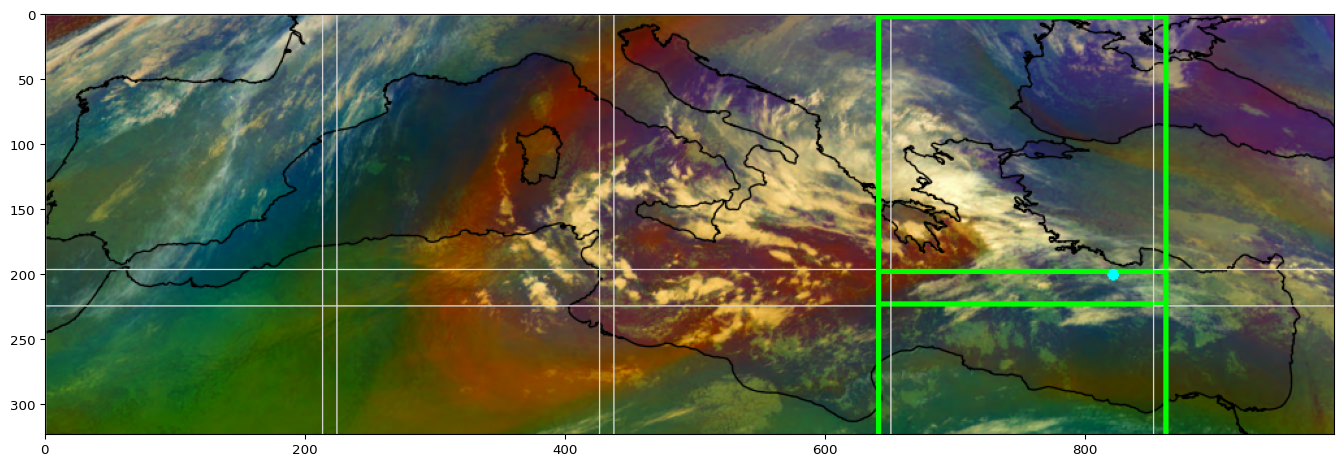

In [14]:
fig = compose_image(819, list_grouped_df, debug=True)

[0 0 0 1 0 0 0 0 0 1 0 0]


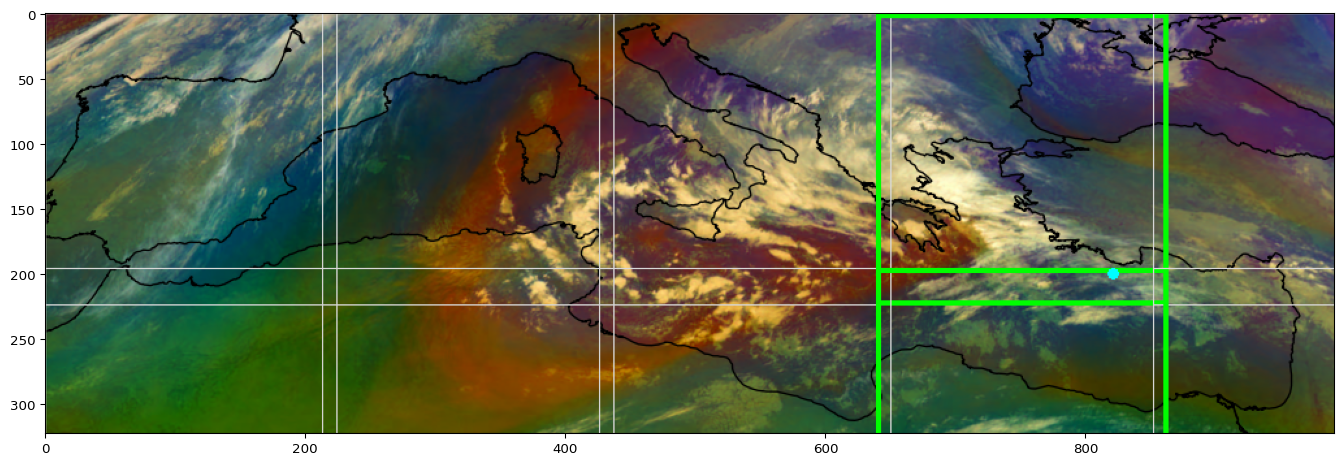

In [36]:
make_animation_parallel_ffmpeg(data_builder.master_df, nomefile=f"ciclone{id_cyc}.mp4")

>>> Generazione dei frame PNG...
 abbiamo 1364 gruppi


NameError: name 'multiprocessing' is not defined

In [33]:
#buffer = io.StringIO()
#manos_sel.to_csv(buffer, index=False)
#buffer.seek(0)

